# Segmentation

In [1]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.3/488.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 14.5 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/controlinpaint/best.pt")  # load a pretrained model (recommended for training)

In [3]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from glob import glob
import numpy as np

In [4]:
def get_mask(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = model.predict(path)[0]

    # mask
    seg_map = {0: '상의', 1: '상의', 2: '하의'}
    human_masks = {}

    for i in range(len(result)):
        box = result.boxes[i]
        mask = result.masks.data[i]
        mask = cv2.resize(mask.cpu().numpy().astype(np.float32), (img.shape[1], img.shape[0]))
        if seg_map[box.cls[0].item()] in human_masks:
            human_masks[seg_map[box.cls[0].item()]] += mask
        else:
            human_masks[seg_map[box.cls[0].item()]] = mask

    return img, human_masks

In [5]:
img, human_masks = get_mask('/content/drive/MyDrive/controlinpaint/sample.jpg')

  0%|          | 0.00/22.2M [00:00<?, ?B/s]

image 1/1 /content/drive/MyDrive/controlinpaint/sample.jpg: 640x640 1 상의, 1 하의, 17.2ms
Speed: 0.9ms preprocess, 17.2ms inference, 54.9ms postprocess per image at shape (1, 3, 640, 640)


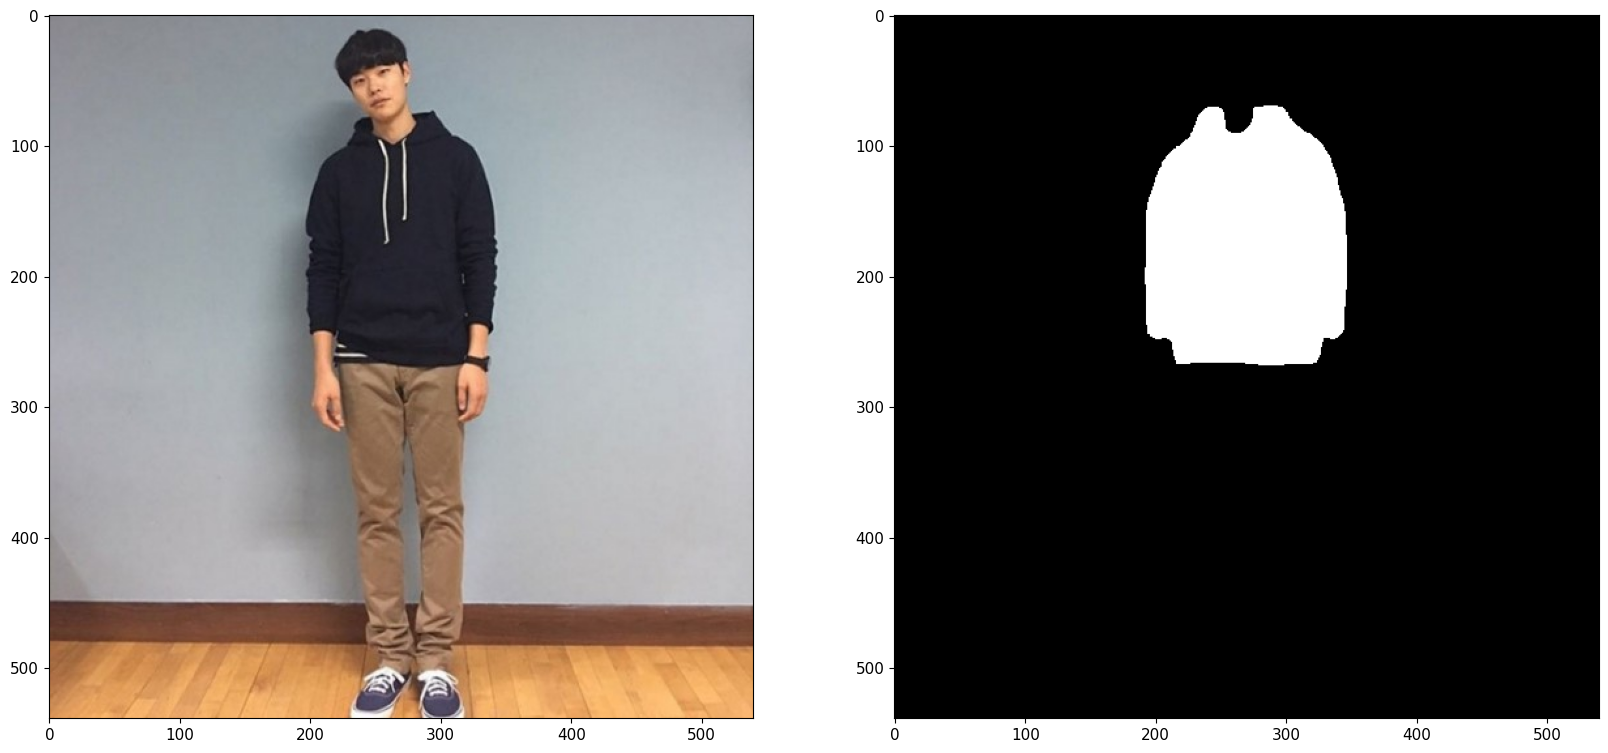

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
mask = human_masks['상의']
mask = np.where(mask != 0, 255.0, 0.0)
plt.imshow(mask, cmap='gray')
plt.show()

In [7]:
img2, human_masks2 = get_mask('/content/drive/MyDrive/controlinpaint/sample2.jpg')
img3, human_masks3 = get_mask('/content/drive/MyDrive/controlinpaint/sample3.jpg')
img4, human_masks4 = get_mask('/content/drive/MyDrive/controlinpaint/sample4.jpg')


image 1/1 /content/drive/MyDrive/controlinpaint/sample2.jpg: 640x448 1 상의, 1 하의, 17.9ms
Speed: 0.6ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/controlinpaint/sample3.jpg: 640x448 1 아우터, 1 하의, 11.4ms
Speed: 0.6ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/controlinpaint/sample4.jpg: 640x448 1 상의, 1 하의, 9.9ms
Speed: 0.5ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


# sd & sd+controlnet (Inpainting)

In [8]:
!pip install torch==1.13.1 diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git -q
!pip install controlnet_aux -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.8 MB/s eta 0:00:00


In [9]:
!git clone https://github.com/panggu15/Virtual-fitting.git
import sys
sys.path.append('Virtual-fitting')

Cloning into 'Virtual-fitting'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), 138.70 KiB | 4.62 MiB/s, done.


In [10]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from pipelines.pipeline_stable_diffusion_controlnet_inpaint import *
from diffusers.utils import load_image

import torch

Error caught was: No module named 'triton'


## Not Controlnet

In [11]:
no_control_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
# no_control_pipe.scheduler = UniPCMultistepScheduler.from_config(no_control_pipe.scheduler.config)

no_control_pipe = no_control_pipe.to('cuda')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

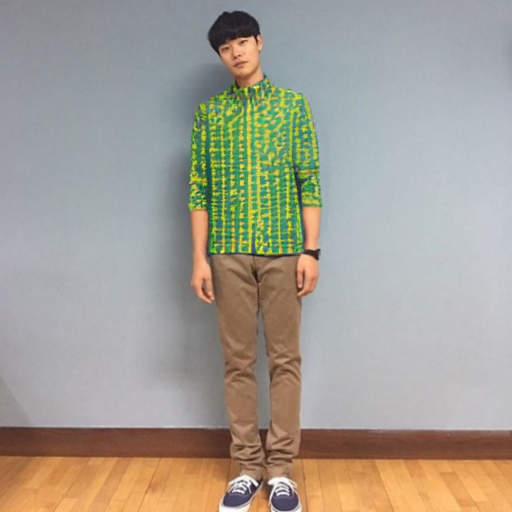

In [12]:
prompt = "man wearing shirt, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

h, w = img.shape[:2]
img = cv2.resize(img, (512, 512))
mask = human_masks['상의']
mask = np.where(mask != 0, 255.0, 0.0)
kernel = np.ones((1, 1), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
mask = cv2.resize(mask, (512, 512))

img=Image.fromarray(img)
mask=Image.fromarray(mask.astype(np.uint8))

image = no_control_pipe(prompt=prompt, negative_prompt=negative_prompt, image=img, mask_image=mask).images[0]

img = np.array(img)
mask = np.array(mask)
result = np.array(image)
result[mask == 0] = img[mask == 0]
image = Image.fromarray(result)
image

## Controlnet (Openpose)

In [13]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()
pipe = pipe.to('cuda')

cuda


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, controlnet, scheduler, safety_checker, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/50 [00:00<?, ?it/s]

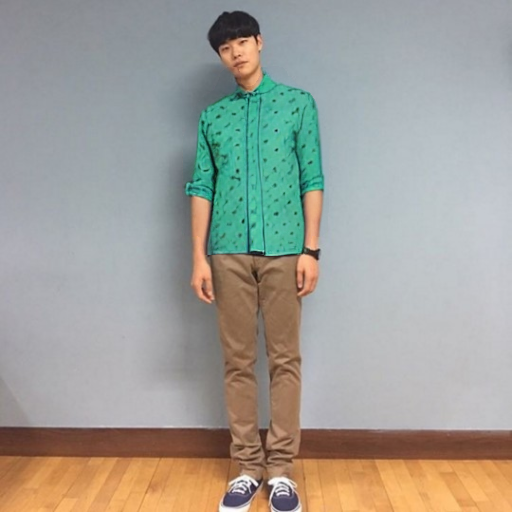

In [14]:
pose_image = openpose(img)

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=img,
    control_image=pose_image,
    mask_image=mask,
    controlnet_conditioning_scale=1.0,
).images[0]

img = np.array(img)
mask = np.array(mask)
result = np.array(new_image)
result[mask == 0] = img[mask == 0]
new_image = Image.fromarray(result)
new_image

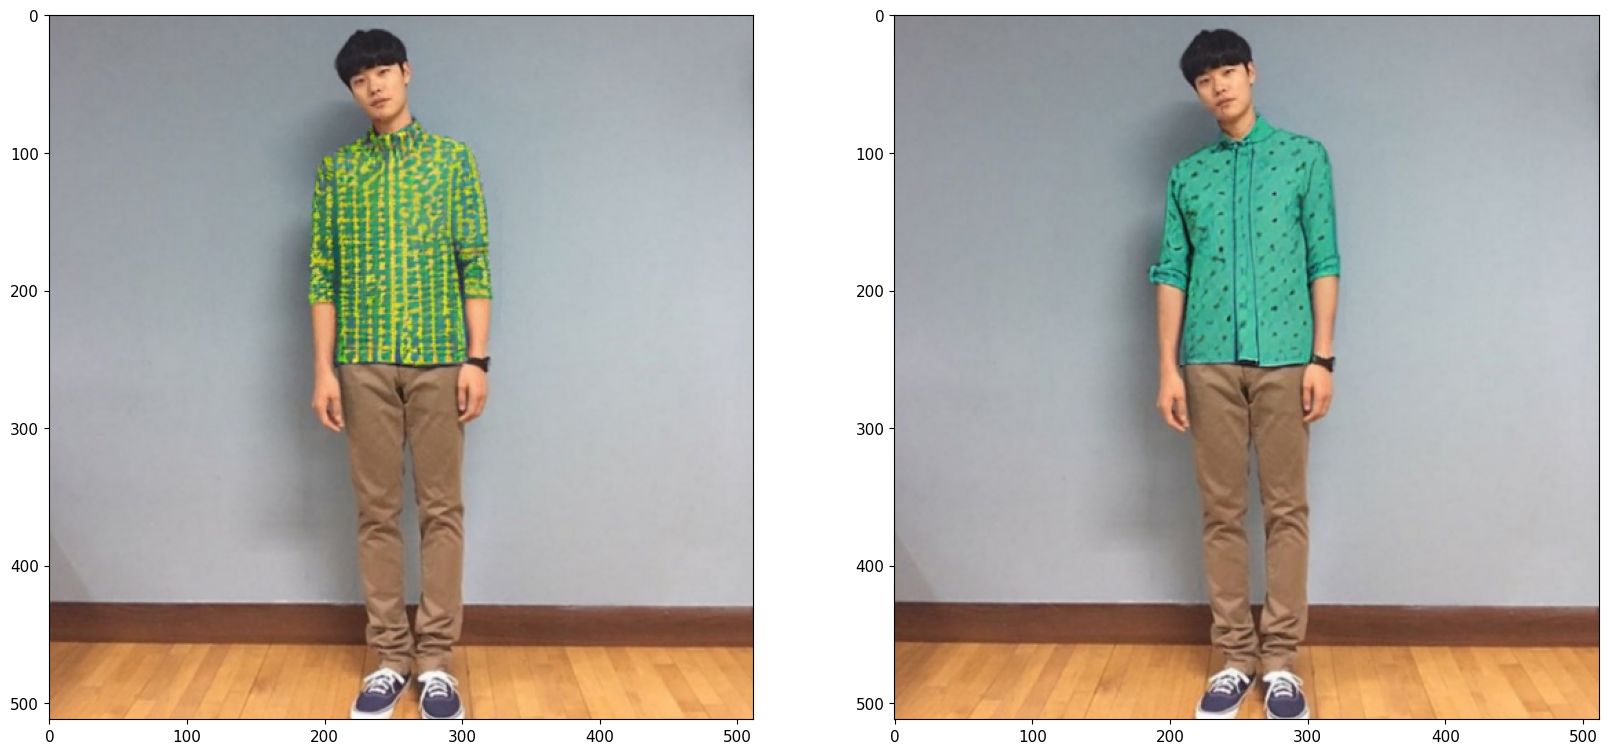

In [15]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
# plt.title('Base')
plt.subplot(1,2,2)
plt.imshow(new_image)
plt.show()

## Other Example

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

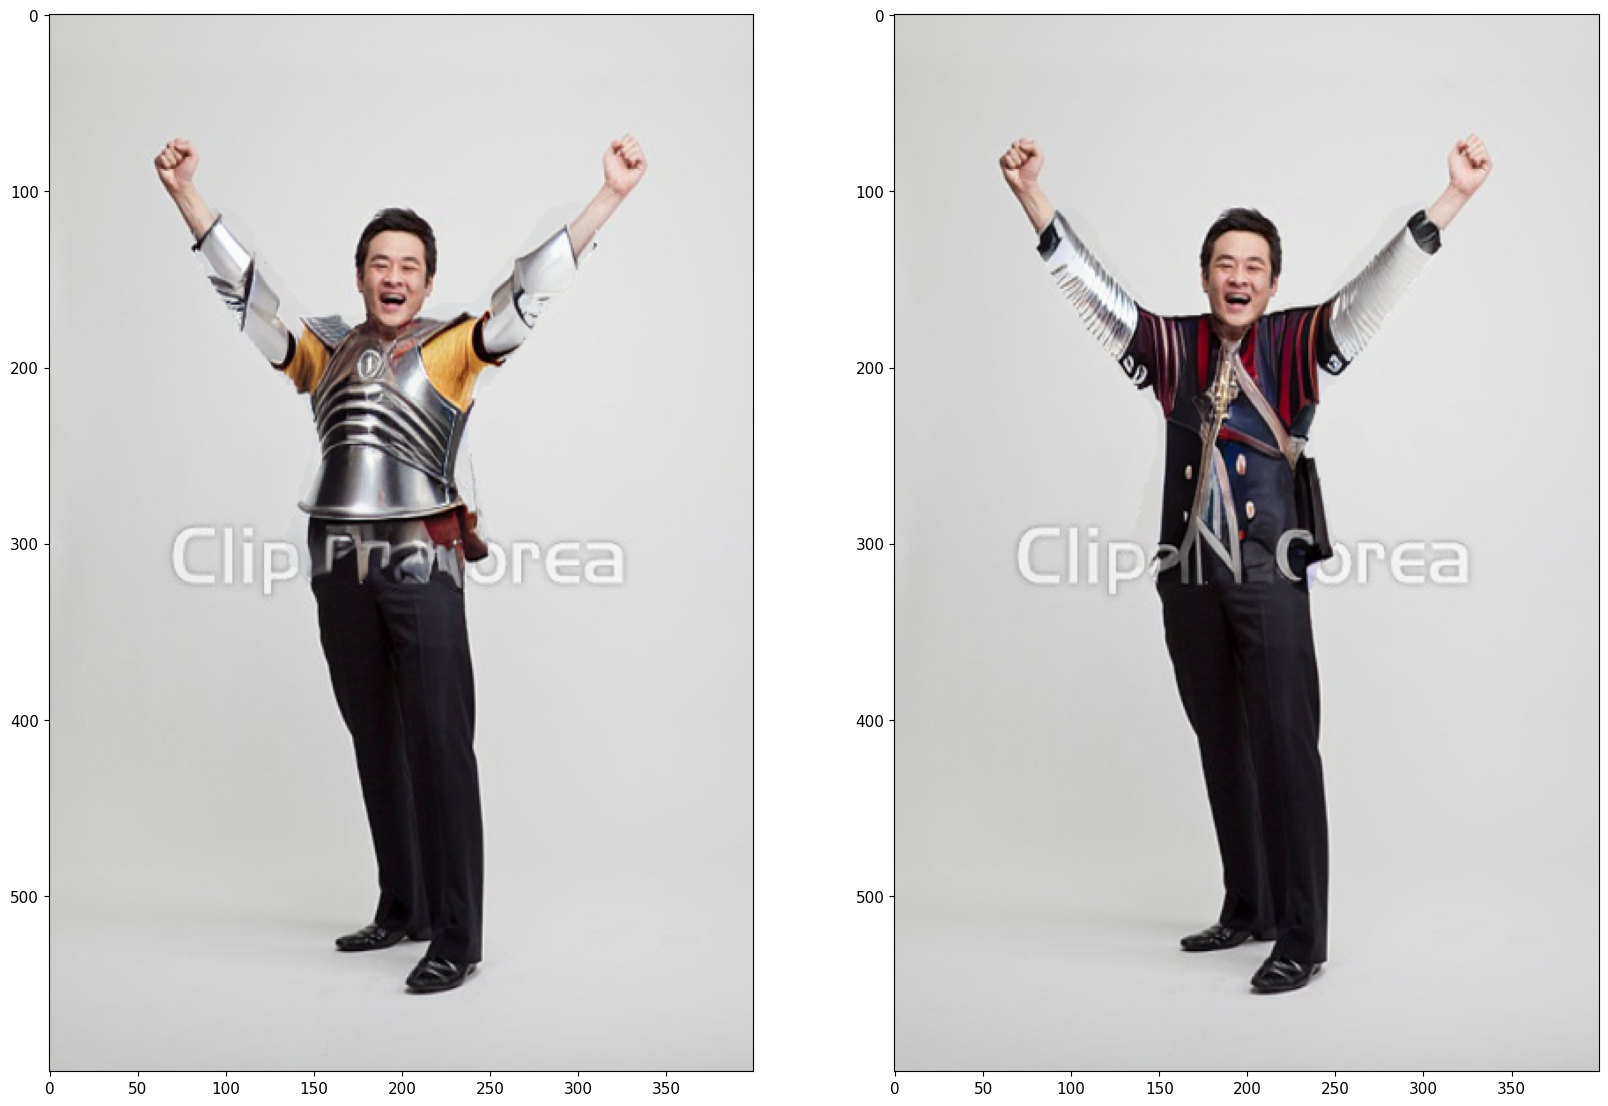

In [16]:
prompt = "a man wearing a knight armor"

h, w = img2.shape[:2]
img = cv2.resize(img2, (512, 512))
mask = human_masks2['상의']
mask = np.where(mask != 0, 255.0, 0.0)
kernel = np.ones((1, 1), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
mask = cv2.resize(mask, (512, 512))

img=Image.fromarray(img)
mask=Image.fromarray(mask.astype(np.uint8))

# Not Controlnet
image = no_control_pipe(prompt=prompt, negative_prompt=negative_prompt, image=img, mask_image=mask).images[0]

# Use Controlnet
pose_image = openpose(img)

# generate image
new_image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=img,
    control_image=pose_image,
    mask_image=mask,
    controlnet_conditioning_scale=0.7,
).images[0]

img = np.array(img)
mask = np.array(mask)
result = np.array(image)
result[mask == 0] = img[mask == 0]
image = Image.fromarray(result)

result = np.array(new_image)
result[mask == 0] = img[mask == 0]
new_image = Image.fromarray(result)

image = image.resize((w, h))
new_image = new_image.resize((w, h))

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(new_image)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

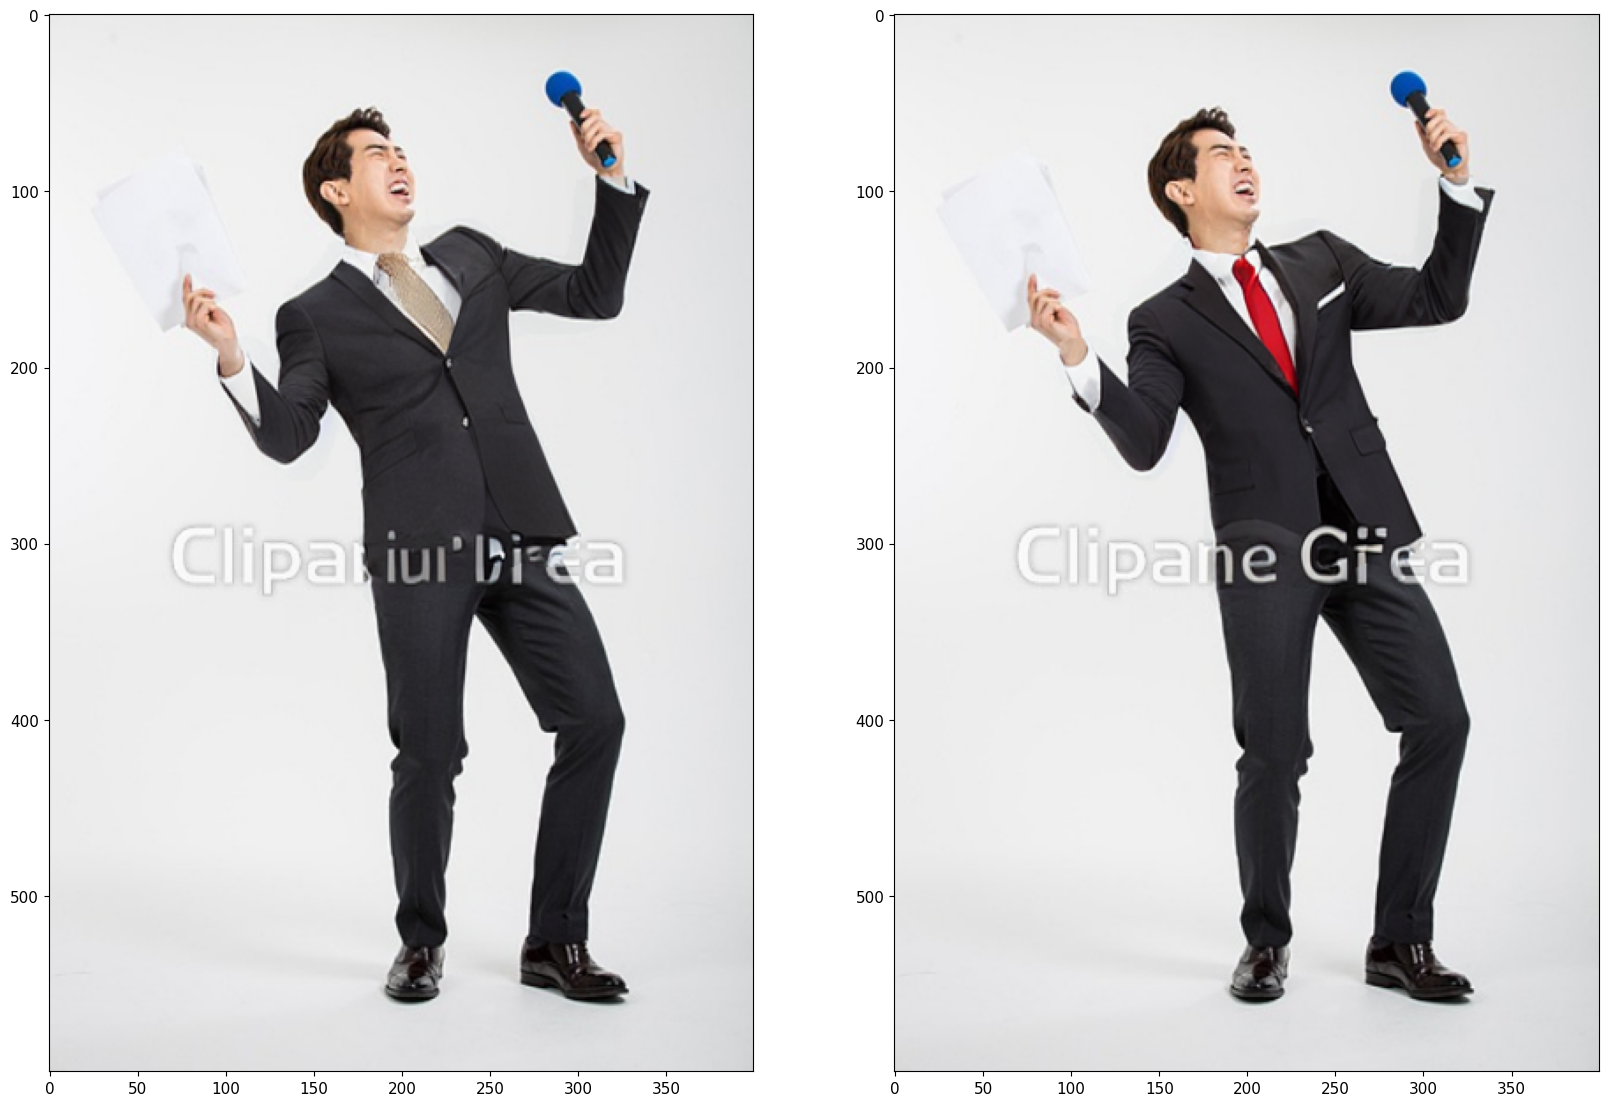

In [17]:
prompt = "a man wearing a suit"

h, w = img3.shape[:2]
img = cv2.resize(img3, (512, 512))
mask = human_masks3['상의']
mask = np.where(mask != 0, 255.0, 0.0)
kernel = np.ones((1, 1), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
mask = cv2.resize(mask, (512, 512))

img=Image.fromarray(img)
mask=Image.fromarray(mask.astype(np.uint8))

# Not Controlnet
image = no_control_pipe(prompt=prompt, negative_prompt=negative_prompt, image=img, mask_image=mask).images[0]

# Use Controlnet
pose_image = openpose(img)

# generate image
new_image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=img,
    control_image=pose_image,
    mask_image=mask,
    controlnet_conditioning_scale=1.0,
).images[0]

img = np.array(img)
mask = np.array(mask)
result = np.array(image)
result[mask == 0] = img[mask == 0]
image = Image.fromarray(result)

result = np.array(new_image)
result[mask == 0] = img[mask == 0]
new_image = Image.fromarray(result)

image = image.resize((w, h))
new_image = new_image.resize((w, h))

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(new_image)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

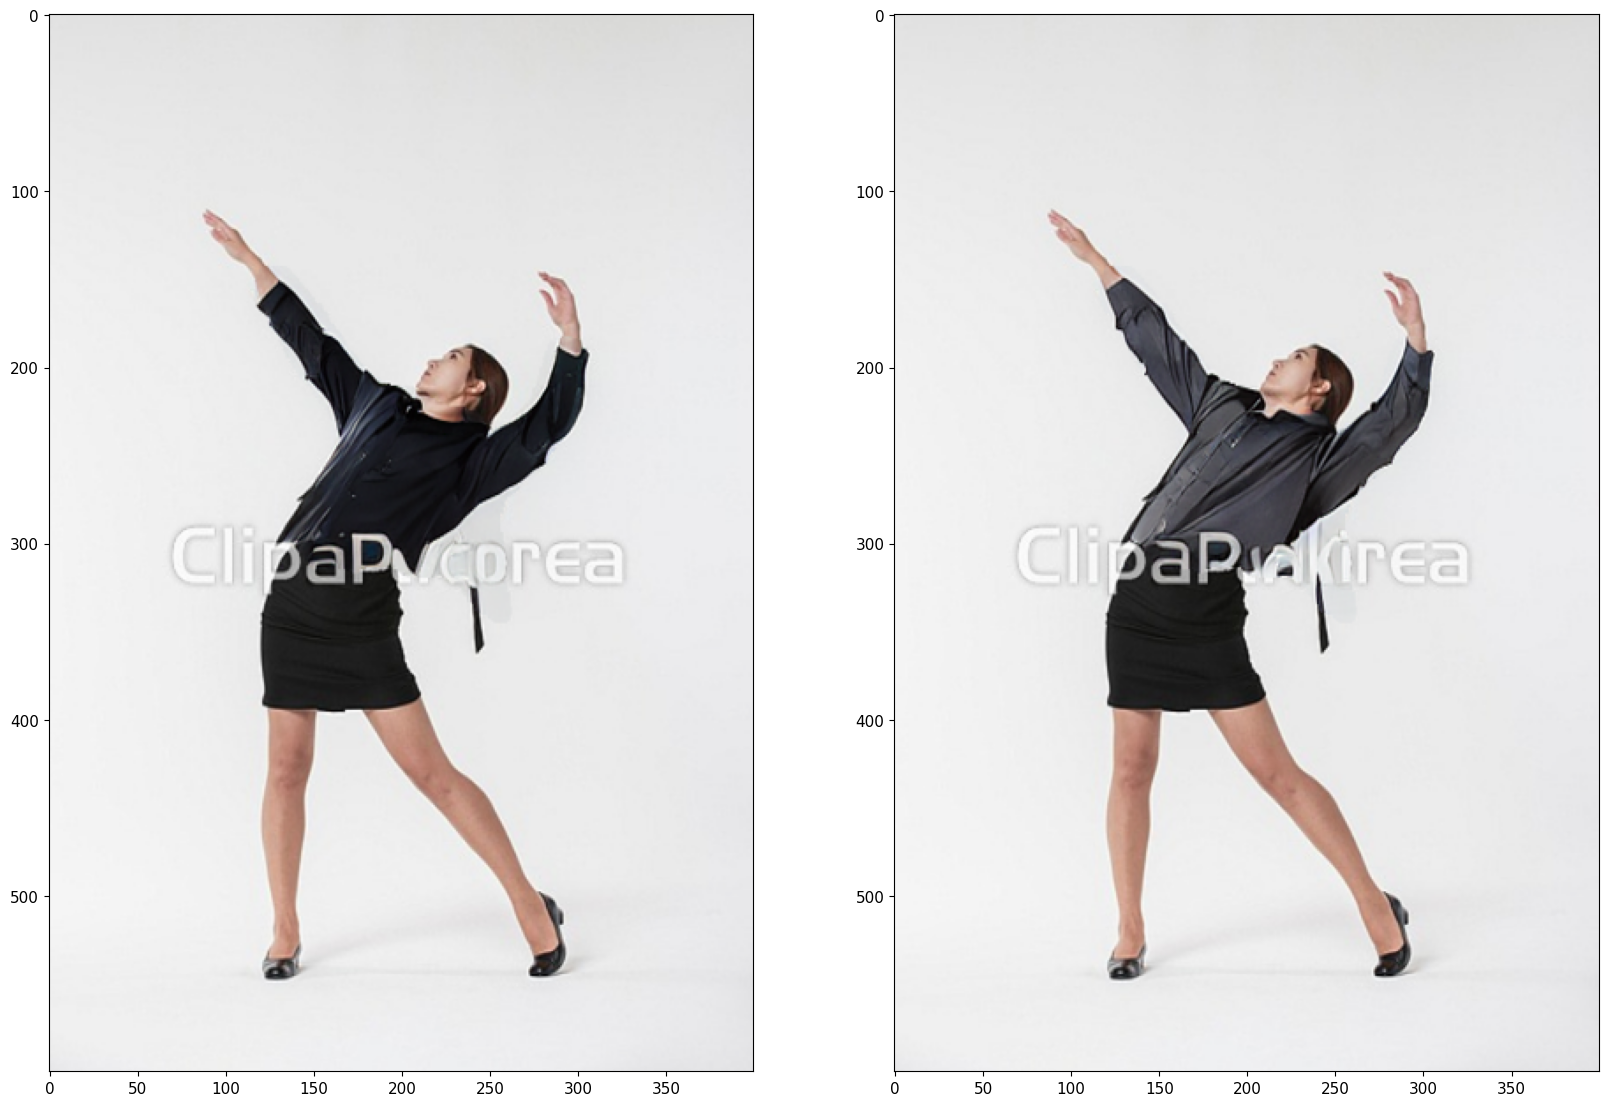

In [19]:
prompt = "a man wearing a shirt"

h, w = img4.shape[:2]
img = cv2.resize(img4, (512, 512))
mask = human_masks4['상의']
mask = np.where(mask != 0, 255.0, 0.0)
kernel = np.ones((1, 1), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
mask = cv2.resize(mask, (512, 512))

img=Image.fromarray(img)
mask=Image.fromarray(mask.astype(np.uint8))

# Not Controlnet
image = no_control_pipe(prompt=prompt, negative_prompt=negative_prompt, image=img, mask_image=mask).images[0]

# Use Controlnet
pose_image = openpose(img)

# generate image
new_image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    generator=generator,
    image=img,
    control_image=pose_image,
    mask_image=mask,
    controlnet_conditioning_scale=1,
).images[0]

img = np.array(img)
mask = np.array(mask)
result = np.array(image)
result[mask == 0] = img[mask == 0]
image = Image.fromarray(result)

result = np.array(new_image)
result[mask == 0] = img[mask == 0]
new_image = Image.fromarray(result)

image = image.resize((w, h))
new_image = new_image.resize((w, h))

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(new_image)
plt.show()